In [1]:
import sys
sys.path.append('../majespy')
import majespy

In [2]:
def rec_ex_optimize(graph, n_steps, commands):
    if n_steps == 0:
        return [(graph, commands)]
    optlist = []
    for m in graph.get_moves():
        new_graph = majespy.apply_move(graph, m)
        optlist += rec_ex_optimize(new_graph, n_steps - 1, commands+[m])
    return optlist

def exhaustive_optimize(graph, n_steps):
    if n_steps == 0:
        return [(graph, [])]
    return rec_ex_optimize(graph, n_steps, [])

def rec_ex_optimize_cutoff(graph, n_steps, cutoff, commands):
    if n_steps == 0:
        return None
    for m in graph.get_moves():
        new_graph = majespy.apply_move(graph, m)
        if new_graph.get_total_nr_nodes() <= cutoff:
            return (new_graph, commands+[m])
        delve = rec_ex_optimize_cutoff(new_graph, n_steps - 1, cutoff, commands+[m])
        if not delve is None:
            return delve
    return None

# Searches until it's done n_stepts or until finds a graph that is the specified nr. of nodes
def exhaustive_optimize_cutoff(graph, n_steps, cutoff):
    return rec_ex_optimize_cutoff(graph, n_steps, cutoff, [])

def select_best_range(graphs_moves, num):
    res = []
    smoves = sorted(graphs_moves, key=lambda t : t[0].get_total_nr_nodes())
    moverange = min(len(graphs_moves), num)
    for i in range(moverange):
        res.append(smoves[i])
    return res
    
def select_best(graphs_moves):
    min_nodes = 100
    best_found = None
    for graph, moves in graphs_moves:
        if graph.get_total_nr_nodes() < min_nodes:
            best_found = (graph, moves)
            min_nodes = graph.get_total_nr_nodes()
    return best_found

def get_graphs(graphs_moves):
    return [graph_move[0] for graph_move in graphs_moves]

def filtered_exhaustive_optimize(graph, n_steps, max_size):
    graphs_moves = [(graph, [])]
   
    for i in range(n_steps):
        new_graphs_moves = []
        for graph, moves in graphs_moves:
            new_graphs_moves += rec_ex_optimize(graph, 1, moves)
        graphs_moves = select_best_range(new_graphs_moves, max_size)
        
    return graphs_moves

def show_graphs(graphs_moves):
    for i in range(len(graphs_moves)):
        graph, moves = graphs_moves[i]
        print("{0}: {1}".format(i, graph.get_total_nr_nodes()))

def assert_all_equal(graph, graphs):
    for i in range(len(graphs)):
        if not graph.equals(graphs[i]):
            print("graphs[{0}] is not equal!".format(i))

In [4]:
amb_mig = majespy.mig_expression_decompose(4, "<<abc>c<cda>>")
amb_opt = majespy.get_optimum_mig(amb_mig)
assert(amb_opt.equals(amb_mig))

print("amb nr nodes: {0}".format(amb_mig.get_total_nr_nodes()))
print("opt nr nodes: {0}".format(amb_opt.get_total_nr_nodes()))

move1g = majespy.apply_move(amb_mig, majespy.PyMove(1, 1))
print("move1 equals: {0}".format(move1g.equals(amb_mig)))
move2g = majespy.apply_move(move1g, majespy.PyMove(6, 7, 5, 1))
print("move2 equals: {0}".format(move2g.equals(amb_mig)))

#graphs_moves = exhaustive_optimize(amb_mig, 3)
#graphs = get_graphs(graphs_moves)
#assert_all_equal(amb_mig, graphs)
#best = select_best(graphs_moves)
#best_graph = best[0]
#print("best nr nodes: {0}".format(best_graph.get_total_nr_nodes()))
#print("best equals: {0}".format(best_graph.equals(amb_mig)))

amb_mig.get_moves()

amb nr nodes: 8
opt nr nodes: 7
move1 equals: True
move2 equals: True


[Move(1:Inverted Propagation,[0]),
 Move(1:Inverted Propagation,[1]),
 Move(1:Inverted Propagation,[2]),
 Move(1:Inverted Propagation,[3]),
 Move(1:Inverted Propagation,[4]),
 Move(1:Inverted Propagation,[5]),
 Move(1:Inverted Propagation,[6]),
 Move(1:Inverted Propagation,[7]),
 Move(4:Swap,[7, 2]),
 Move(5:Distributivity R->L,[7, 3]),
 Move(4:Swap,[7, 4]),
 Move(6:Swap3,[7, 5, 1]),
 Move(7:Distributivity L->R,[7, 5, 1]),
 Move(6:Swap3,[7, 5, 2]),
 Move(7:Distributivity L->R,[7, 5, 2]),
 Move(7:Distributivity L->R,[7, 5, 3]),
 Move(6:Swap3,[7, 6, 1]),
 Move(7:Distributivity L->R,[7, 6, 1]),
 Move(7:Distributivity L->R,[7, 6, 3]),
 Move(6:Swap3,[7, 6, 4]),
 Move(7:Distributivity L->R,[7, 6, 4])]

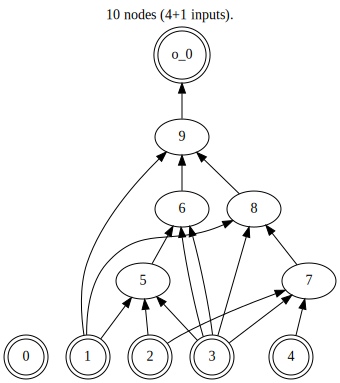

In [11]:
from ipywidgets import interact, IntSlider

movegraph1 = majespy.apply_move(amb_mig, majespy.PyMove(7, 7, 6, 1))
assert(movegraph1.equals(amb_mig))
movegraph2 = majespy.apply_move(movegraph1, majespy.PyMove(4, 7, 1))
assert(movegraph2.equals(amb_mig))
movegraph3 = majespy.apply_move(movegraph1, majespy.PyMove(5, 9, 1))
#assert(movegraph3.equals(amb_mig))

viz_graphs = [ amb_mig.plot(), movegraph1.plot(), movegraph2.plot() ]

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))

In [5]:
graphs_moves = exhaustive_optimize(amb_mig, 3)
graphs = get_graphs(graphs_moves)
assert_all_equal(amb_mig, graphs)
best = select_best(graphs_moves)
print("best nr nodes: {0}".format(best[0].get_total_nr_nodes()))

best nr nodes: 7


In [ ]:
nr_inputs = 3
nr_funcs = 2**(2**nr_inputs)
nr_strash_equals = 0
nr_paths_found = 0
graphs_found = []
lookahead = 3
errormig = None
for i in range(nr_funcs):
    mig_from_func = majespy.mig_int_decompose(3, i)
    strashed_mig = majespy.strash_xmg(mig_from_func)
    opt_mig = majespy.get_optimum_mig(mig_from_func)
    assert(opt_mig.equals(mig_from_func))
    if opt_mig.get_total_nr_nodes() == strashed_mig.get_total_nr_nodes():
        nr_strash_equals += 1
        graphs_found.append((strashed_mig, []))
        continue
    # Try to find a path to an optimum
    found = exhaustive_optimize_cutoff(mig_from_func, lookahead, opt_mig.get_total_nr_nodes())
    if not found is None:
        if not found[0].equals(opt_mig):
            print("Error at {0}, moves: {1}".format(i, found[1]))
            errormig = found[0]
            assert(False)
        graphs_found.append(found)
        nr_paths_found += 1
    print("({0}/{1})".format(i+1, nr_funcs))
    #print("strashed mig nr: {0}".format(strashed_mig.get_total_nr_nodes()))
    #print("opt mig nr: {0}".format(opt_mig.get_total_nr_nodes()))
    #print("=============================")

(4/256)
(6/256)
(7/256)
(8/256)
(10/256)
(11/256)
(12/256)
(13/256)
(14/256)
(15/256)
(16/256)
(19/256)
(20/256)
(21/256)
(22/256)
(23/256)
(24/256)
(25/256)
(27/256)
(28/256)
(29/256)
(30/256)
(31/256)
(32/256)
(34/256)
(36/256)
(37/256)
(38/256)
(40/256)
(41/256)
(42/256)
(43/256)
(44/256)
(45/256)


In [ ]:
print("lookahead: {0}".format(lookahead))
print("nr strash equals: {0}".format(nr_strash_equals))
print("nr paths found: {0}".format(nr_paths_found))
print("nr remaining: {0}".format(nr_funcs-nr_strash_equals-nr_paths_found))

In [29]:
m = majespy.mig_int_decompose(3, 21)
om = majespy.get_optimum_mig(m)
sm = majespy.strash_xmg(m)
assert(m.equals(om))
assert(m.equals(sm))
mom1 = majespy.apply_move(sm, majespy.PyMove(6, 5, 4, 0))
assert(m.equals(mom1))
mom2 = majespy.apply_move(mom1, majespy.PyMove(0, 4))
assert(m.equals(mom2))
mom3 = majespy.apply_move(mom2, majespy.PyMove(0, 5))
assert(m.equals(mom3))

assert(m.equals(errormig))

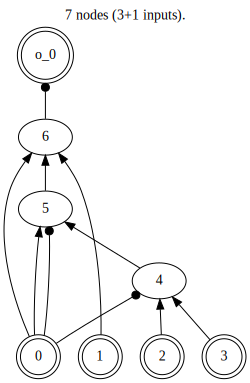

In [25]:
from ipywidgets import interact, IntSlider


viz_graphs = [ sm.plot(), mom1.plot(), mom2.plot() ]

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))

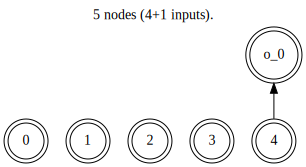

<function __main__.<lambda>>

In [9]:
test = majespy.mig_expression_decompose(4, "0")
viz_graphs = [ test.plot() ]

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))